# II. Agent learning by algorithm

## 1. VI

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML # For displaying in notebooks

class GridWorld:
    def __init__(self, height=5, width=5, agent_location=None, target_location=None):
        self.size = (height, width)
        self.action_space_size = 5  # 0: up, 1: down, 2: left, 3: right
        self.action2direction = {
            0: np.array([-1, 0]),  # up
            1: np.array([1, 0]),   # down
            2: np.array([0, -1]),  # left
            3: np.array([0, 1]), # right
            4: np.array([0, 1]) # stay
        }

        
        self.agent_location = agent_location
        self.target_location = target_location

        if self.target_location is None:
            self.target_location = (np.random.randint(0, self.size[0]), np.random.randint(0, self.size[1]))


        if self.agent_location is None:
            while True:
                self.agent_location = (np.random.randint(0, self.size[0]), np.random.randint(0, self.size[1]))
                if self.agent_location != self.target_location:
                    break


        self.history = []
        self.reset()

    def get_state_space_size(self):
        return self.size[0] * self.size[1]
    
    def get_all_states(self):
        states = []
        for r in range(self.size[0]):
            for c in range(self.size[1]):
                states.append((r,c))
        return states

    def reset(self):
            
        self.history = [{'agent': self.agent_location, 'target': self.target_location, 'reward': 0}]
        return self.agent_location

    def step(self, action):
        agent_pos = np.array(self.agent_location)
        direction = self.action2direction[action]
        next_pos = agent_pos + direction

        # Check boundaries
        if (0 <= next_pos[0] < self.size[0]) and (0 <= next_pos[1] < self.size[1]):
            self.agent_location = tuple(next_pos)

        finished = (self.agent_location == self.target_location)
        reward = 10 if finished else -1

        self.history.append({'agent': self.agent_location, 'target': self.target_location, 'reward': reward})
        return self.agent_location, reward, finished

    def set_history(self, history):
        """Allows a solver to set the history for visualization."""
        self.history = history


    def Create_Visualization(self):
        fig, ax = plt.subplots(figsize=(7, 8))
        fig.subplots_adjust(bottom=0.15)
    
        def setup_grid():
            ax.set_xlim(-0.5, self.size[1] - 0.5)
            ax.set_ylim(-0.5, self.size[0] - 0.5)
    
            ax.set_xticks(np.arange(-0.5, self.size[1], 1), minor=True)
            ax.set_yticks(np.arange(-0.5, self.size[0], 1), minor=True)
            ax.grid(which='minor', color='#CCCCCC', linestyle='-', linewidth=1)
            ax.tick_params(which='minor', bottom=False, left=False, labelbottom=False, labelleft=False)
            ax.set_aspect('equal', adjustable='box')
            ax.invert_yaxis()
    
        setup_grid()
    
        # target drawing
        target_pos = self.history[0]['target']
        ax.scatter(target_pos[1], target_pos[0], marker=(5, 1, 0), s=800, c='#FFD700',
                   edgecolors='black', zorder=5, label='Target')
    
        # agent + path drawing
        agent_marker = ax.scatter([], [], s=400, c='#0077BE', edgecolors='white',
                                  linewidth=2, zorder=5, label='Agent')
        path_line, = ax.plot([], [], color='#0077BE', alpha=0.5, linewidth=4, zorder=4)
    
        ax.legend(loc='upper right')
    
        info_text = fig.text(0.5, 0.05, '', ha='center', fontsize=16, fontweight='bold',
                             bbox=dict(boxstyle='round,pad=0.5', fc='lightgray', alpha=0.5))
    
        cumulative_rewards = np.cumsum([frame['reward'] for frame in self.history])
    
        def update(frame_num):
            current_frame = self.history[frame_num]
            agent_pos = current_frame['agent']
    
            # Update agent
            agent_marker.set_offsets([agent_pos[1], agent_pos[0]])
    
            # Update path
            path_rows, path_cols = zip(*[f['agent'] for f in self.history[:frame_num + 1]])
            path_line.set_data(path_cols, path_rows)
    
            # Title and info text
            ax.set_title(f"Agent at: {agent_pos}", fontsize=14)
            total_reward_so_far = cumulative_rewards[frame_num]
            info_text.set_text(f"Step: {frame_num:02d}    |    Cumulative Reward: {total_reward_so_far}")
    
            if frame_num == len(self.history) - 1 and agent_pos == target_pos:
                ax.set_title("Target Reached!", fontsize=16, color='green')
    
            return agent_marker, path_line, info_text
    
        anim = FuncAnimation(fig, update, frames=len(self.history), interval=250, blit=False)
    
        plt.close(fig)
        return anim

In [ ]:
# (Keep all the previous classes: GridWorld, Solver, ValueIterationSolver, etc.)
# We will just add this new method inside the Solver class definition.

class Solver:
    def __init__(self, env, discount_factor=0.99):
        self.env = env
        self.gamma = discount_factor
        self.policy = np.zeros(self.env.size, dtype=int)

    def solve(self):
        """Learns the optimal policy."""
        raise NotImplementedError("This method should be implemented by a subclass.")

    def get_policy(self):
        return self.policy
    
    # ===================================================================
    # NEW METHOD TO PLOT THE POLICY
    # ===================================================================
    def plot_policy(self):
        """Visualizes the learned policy using arrows."""
        fig, ax = plt.subplots(figsize=(8, 8))

        # --- Setup Grid ---
        ax.set_xlim(-0.5, self.env.size[1] - 0.5)
        ax.set_ylim(-0.5, self.env.size[0] - 0.5)
        ax.set_xticks(np.arange(-0.5, self.env.size[1], 1))
        ax.set_yticks(np.arange(-0.5, self.env.size[0], 1))
        ax.grid(which='major', color='#CCCCCC', linestyle='-', linewidth=1)
        ax.tick_params(which='major', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.invert_yaxis()
        ax.set_title("Learned Policy", fontsize=16)

        # --- Mark Start and Target ---
        target_pos = self.env.target_location
        start_pos = self.env.agent_location
        ax.scatter(target_pos[1], target_pos[0], marker=(5, 1, 0), s=1000, c='#FFD700', edgecolors='black', zorder=5, label='Target')
        if start_pos:
            ax.scatter(start_pos[1], start_pos[0], s=500, c='#0077BE', edgecolors='white', linewidth=2, zorder=5, label='Start')

        # --- Prepare Arrow Data ---
        # Get coordinates for each cell
        rows, cols = np.indices(self.env.size)
        col_coords = cols.flatten()
        row_coords = rows.flatten()
        
        # Get action vectors from the policy
        # action2direction maps: 0:up(-1,0), 1:down(1,0), 2:left(0,-1), 3:right(0,1)
        policy_actions = self.policy.flatten()
        action_vectors = np.array([self.env.action2direction[a] for a in policy_actions])
        
        # dy corresponds to row change, dx to column change
        dy = action_vectors[:, 0]
        dx = action_vectors[:, 1]

        # Don't draw an arrow in the target state
        target_flat_idx = target_pos[0] * self.env.size[1] + target_pos[1]
        dx[target_flat_idx] = 0
        dy[target_flat_idx] = 0

        # --- Draw Arrows ---
        # We use -dy because the y-axis is inverted (row 0 is at the top)
        ax.quiver(col_coords, row_coords, dx, -dy, 
                  scale=35,      # Controls arrow size, larger scale = smaller arrows
                  color='#333333',
                  headwidth=4,
                  headlength=5,
                  pivot='mid')   # Draw arrow from the center of the cell

        ax.legend(loc='upper right')
        plt.show()

    def run_simulation(self, max_steps=100):
        """Runs one episode using the learned policy and returns the history."""
        self.env.reset()
        # Make a deep copy to ensure the simulation history is fresh
        history = [self.env.history[0].copy()] 
        
        for _ in range(max_steps):
            current_state = self.env.agent_location
            action = self.policy[current_state]
            _, _, finished = self.env.step(action)
            # Append the latest step from the env's history to our simulation history
            history.append(self.env.history[-1])
            if finished:
                break
        return history

In [ ]:
class ValueIterationSolver(Solver):
    def __init__(self, env, discount_factor=0.99, theta=1e-6):
        super().__init__(env, discount_factor)
        self.theta = theta # A small threshold to check for convergence
        self.value_table = np.zeros(self.env.size)

    def _get_action_value(self, state, action):
        """Helper to calculate the value of taking an action in a state."""
        original_pos = self.env.agent_location
        self.env.agent_location = state # Temporarily set agent position
        
        next_state, reward, _ = self.env.step(action)
        action_value = reward + self.gamma * self.value_table[next_state]
        
        self.env.agent_location = original_pos # Reset position
        return action_value

    def solve(self):
        print("Starting Value Iteration...")
        delta = float('inf')
        
        # Main loop: iterate until the value function converges
        while delta > self.theta:
            delta = 0
            for r in range(self.env.size[0]):
                for c in range(self.env.size[1]):
                    state = (r, c)
                    if state == self.env.target_location:
                        continue
                        
                    old_value = self.value_table[state]
                    action_values = [self._get_action_value(state, a) for a in range(self.env.action_space_size)]
                    
                    self.value_table[state] = max(action_values)
                    delta = max(delta, abs(old_value - self.value_table[state]))

        print("Value Iteration Converged.")
        # Extract the optimal policy
        for r in range(self.env.size[0]):
            for c in range(self.env.size[1]):
                state = (r, c)
                action_values = [self._get_action_value(state, a) for a in range(self.env.action_space_size)]
                self.policy[state] = np.argmax(action_values)

Starting Value Iteration...
Value Iteration Converged.
Solving took 0.0339 seconds.

Displaying the learned policy:


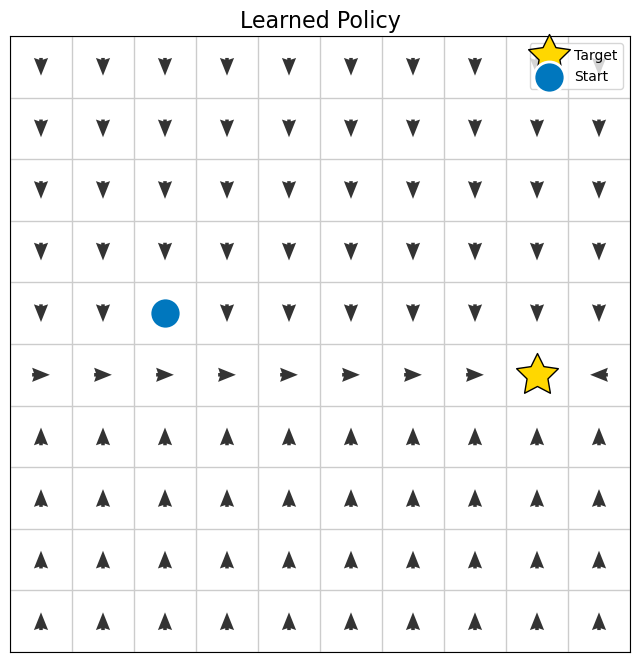


Displaying the agent's path animation:


In [ ]:
# --- Common Setup ---
GRID_HEIGHT = 10
GRID_WIDTH = 10
AGENT_START = None
TARGET_POS = None

# 1. Create the environment with a fixed start and target
env = GridWorld(height=GRID_HEIGHT, width=GRID_WIDTH, 
                agent_location=AGENT_START, target_location=TARGET_POS)


# --- Choose Your Algorithm ---
solver = ValueIterationSolver(env)
# solver = PolicyIterationSolver(env)
# solver = QLearningSolver(env, num_episodes=5000)


# 2. Solve the MDP to find the optimal policy
start_time = time.time()
solver.solve()
end_time = time.time()
print(f"Solving took {end_time - start_time:.4f} seconds.")

# ===================================================================
# 3. PLOT THE EXTRACTED POLICY (NEW STEP)
# ===================================================================
print("\nDisplaying the learned policy:")
solver.plot_policy()


# 4. Run a simulation using the learned policy
history = solver.run_simulation(max_steps=100)

# 5. Set the simulation history in the environment and visualize the agent's path
print("\nDisplaying the agent's path animation:")
env.set_history(history)
anim = env.Create_Visualization()

# Display the animation in a Jupyter Notebook or save it
HTML(anim.to_html5_video())
# To save: anim.save('gridworld_solution.mp4', writer='ffmpeg')

## 2. PI

In [ ]:
class PolicyIterationSolver(Solver):
    def __init__(self, env, discount_factor=0.99, theta=1e-6):
        super().__init__(env, discount_factor)
        self.theta = theta
        self.value_table = np.zeros(self.env.size)
        # Start with a random policy
        self.policy = np.random.randint(0, self.env.action_space_size, self.env.size)

    def _get_action_value(self, state, action):
        """Helper to calculate the value of taking an action in a state."""
        original_pos = self.env.agent_location
        self.env.agent_location = state
        
        next_state, reward, _ = self.env.step(action)
        action_value = reward + self.gamma * self.value_table[next_state]
        
        self.env.agent_location = original_pos
        return action_value

    def _policy_evaluation(self):
        """Update the value table based on the current policy."""
        delta = float('inf')
        while delta > self.theta:
            delta = 0
            for r in range(self.env.size[0]):
                for c in range(self.env.size[1]):
                    state = (r, c)
                    old_value = self.value_table[state]
                    action = self.policy[state]
                    self.value_table[state] = self._get_action_value(state, action)
                    delta = max(delta, abs(old_value - self.value_table[state]))

    def _policy_improvement(self):
        """Update the policy based on the current value table."""
        policy_stable = True
        for r in range(self.env.size[0]):
            for c in range(self.env.size[1]):
                state = (r, c)
                old_action = self.policy[state]
                
                action_values = [self._get_action_value(state, a) for a in range(self.env.action_space_size)]
                self.policy[state] = np.argmax(action_values)
                
                if old_action != self.policy[state]:
                    policy_stable = False
        return policy_stable

    def solve(self):
        print("Starting Policy Iteration...")
        policy_stable = False
        iteration = 1
        while not policy_stable:
            print(f"  Iteration {iteration}...")
            self._policy_evaluation()
            policy_stable = self._policy_improvement()
            iteration += 1
        print("Policy Iteration Converged.")

Starting Policy Iteration...
  Iteration 1...
  Iteration 2...
  Iteration 3...
  Iteration 4...
  Iteration 5...
  Iteration 6...
  Iteration 7...
  Iteration 8...
  Iteration 9...
  Iteration 10...
Policy Iteration Converged.
Solving took 1.2332 seconds.

Displaying the learned policy:


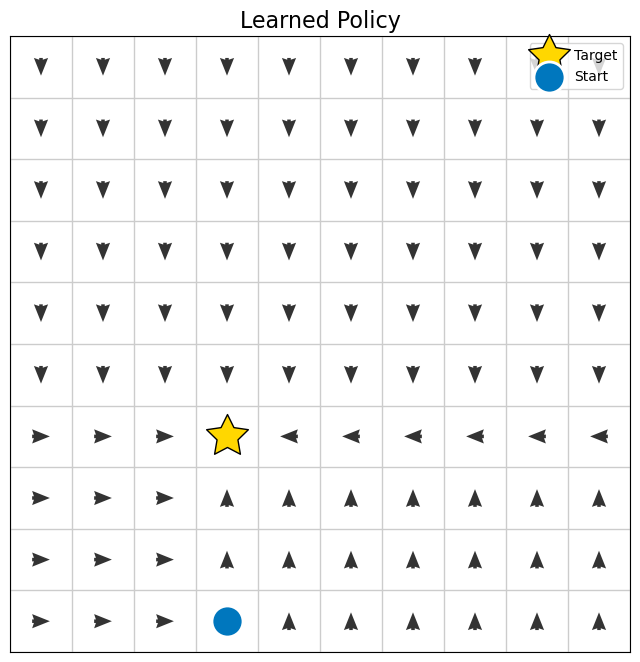


Displaying the agent's path animation:


In [ ]:
# --- Common Setup ---
GRID_HEIGHT = 10
GRID_WIDTH = 10
AGENT_START = None
TARGET_POS = None

# 1. Create the environment with a fixed start and target
env = GridWorld(height=GRID_HEIGHT, width=GRID_WIDTH, 
                agent_location=AGENT_START, target_location=TARGET_POS)


# --- Choose Your Algorithm ---
solver = PolicyIterationSolver(env)
# solver = PolicyIterationSolver(env)
# solver = QLearningSolver(env, num_episodes=5000)


# 2. Solve the MDP to find the optimal policy
start_time = time.time()
solver.solve()
end_time = time.time()
print(f"Solving took {end_time - start_time:.4f} seconds.")

# ===================================================================
# 3. PLOT THE EXTRACTED POLICY (NEW STEP)
# ===================================================================
print("\nDisplaying the learned policy:")
solver.plot_policy()


# 4. Run a simulation using the learned policy
history = solver.run_simulation(max_steps=100)

# 5. Set the simulation history in the environment and visualize the agent's path
print("\nDisplaying the agent's path animation:")
env.set_history(history)
anim = env.Create_Visualization()

# Display the animation in a Jupyter Notebook or save it
HTML(anim.to_html5_video())
# To save: anim.save('gridworld_solution.mp4', writer='ffmpeg')

## 3.The whole framework: with MC and Q_learning

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML # For displaying in notebooks

class GridWorld:
    def __init__(self, height=5, width=5, agent_location=None, target_location=None):
        self.size = (height, width)
        self.action_space_size = 5  # 0: up, 1: down, 2: left, 3: right, 4: stay
        self.action2direction = {
            0: np.array([-1, 0]),  # up
            1: np.array([1, 0]),   # down
            2: np.array([0, -1]),  # left
            3: np.array([0, 1]),   # right
            4: np.array([0, 0])    # stay  <- CORRECTED
        }
        
        # Store initial locations to be used by reset()
        self._initial_agent_location = agent_location
        self._initial_target_location = target_location

        self.target_location = self._initial_target_location
        if self.target_location is None:
            self.target_location = (np.random.randint(0, self.size[0]), np.random.randint(0, self.size[1]))

        self.agent_location = self._initial_agent_location
        if self.agent_location is None:
            while True:
                self.agent_location = (np.random.randint(0, self.size[0]), np.random.randint(0, self.size[1]))
                if self.agent_location != self.target_location:
                    break
        # Store the true starting point after potential randomization
        self._initial_agent_location = self.agent_location
        
        self.history = []
        self.reset()

    def get_state_space_size(self):
        return self.size[0] * self.size[1]
    
    def get_all_states(self):
        states = []
        for r in range(self.size[0]):
            for c in range(self.size[1]):
                states.append((r,c))
        return states

    def reset(self):
        """ Resets the agent to its initial starting position. """
        self.agent_location = self._initial_agent_location
        self.history = [{'agent': self.agent_location, 'target': self.target_location, 'reward': 0}]
        return self.agent_location

    def step(self, action):
        agent_pos = np.array(self.agent_location)
        direction = self.action2direction[action]
        next_pos = agent_pos + direction

        # Check boundaries
        if (0 <= next_pos[0] < self.size[0]) and (0 <= next_pos[1] < self.size[1]):
            self.agent_location = tuple(next_pos)

        finished = (self.agent_location == self.target_location)
        reward = 10 if finished else -1

        self.history.append({'agent': self.agent_location, 'target': self.target_location, 'reward': reward})
        return self.agent_location, reward, finished

    def set_history(self, history):
        """Allows a solver to set the history for visualization."""
        self.history = history

    def Create_Visualization(self):
        fig, ax = plt.subplots(figsize=(7, 8))
        fig.subplots_adjust(bottom=0.15)
    
        def setup_grid():
            ax.set_xlim(-0.5, self.size[1] - 0.5)
            ax.set_ylim(-0.5, self.size[0] - 0.5)
    
            ax.set_xticks(np.arange(-0.5, self.size[1], 1), minor=True)
            ax.set_yticks(np.arange(-0.5, self.size[0], 1), minor=True)
            ax.grid(which='minor', color='#CCCCCC', linestyle='-', linewidth=1)
            ax.tick_params(which='minor', bottom=False, left=False, labelbottom=False, labelleft=False)
            ax.set_aspect('equal', adjustable='box')
            ax.invert_yaxis()
    
        setup_grid()
    
        # target drawing
        target_pos = self.history[0]['target']
        ax.scatter(target_pos[1], target_pos[0], marker=(5, 1, 0), s=800, c='#FFD700',
                   edgecolors='black', zorder=5, label='Target')
    
        # agent + path drawing
        agent_marker = ax.scatter([], [], s=400, c='#0077BE', edgecolors='white',
                                   linewidth=2, zorder=5, label='Agent')
        path_line, = ax.plot([], [], color='#0077BE', alpha=0.5, linewidth=4, zorder=4)
    
        ax.legend(loc='upper right')
    
        info_text = fig.text(0.5, 0.05, '', ha='center', fontsize=16, fontweight='bold',
                             bbox=dict(boxstyle='round,pad=0.5', fc='lightgray', alpha=0.5))
    
        cumulative_rewards = np.cumsum([frame['reward'] for frame in self.history])
    
        def update(frame_num):
            current_frame = self.history[frame_num]
            agent_pos = current_frame['agent']
    
            # Update agent
            agent_marker.set_offsets([agent_pos[1], agent_pos[0]])
    
            # Update path
            path_rows, path_cols = zip(*[f['agent'] for f in self.history[:frame_num + 1]])
            path_line.set_data(path_cols, path_rows)
    
            # Title and info text
            ax.set_title(f"Agent at: {agent_pos}", fontsize=14)
            total_reward_so_far = cumulative_rewards[frame_num]
            info_text.set_text(f"Step: {frame_num:02d}     |     Cumulative Reward: {total_reward_so_far}")
    
            if frame_num == len(self.history) - 1 and agent_pos == target_pos:
                ax.set_title("Target Reached!", fontsize=16, color='green')
    
            return agent_marker, path_line, info_text
    
        anim = FuncAnimation(fig, update, frames=len(self.history), interval=250, blit=False)
    
        plt.close(fig)
        return anim

class Solver:
    def __init__(self, env, discount_factor=0.99):
        self.env = env
        self.gamma = discount_factor
        self.policy = np.zeros(self.env.size, dtype=int)

    def solve(self):
        """Learns the optimal policy."""
        raise NotImplementedError("This method should be implemented by a subclass.")

    def get_policy(self):
        return self.policy
    
    def plot_policy(self):
        """Visualizes the learned policy using arrows."""
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.set_xlim(-0.5, self.env.size[1] - 0.5)
        ax.set_ylim(-0.5, self.env.size[0] - 0.5)
        ax.set_xticks(np.arange(-0.5, self.env.size[1], 1))
        ax.set_yticks(np.arange(-0.5, self.env.size[0], 1))
        ax.grid(which='major', color='#CCCCCC', linestyle='-', linewidth=1)
        ax.tick_params(which='major', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.invert_yaxis()
        ax.set_title("Learned Policy", fontsize=16)

        target_pos = self.env.target_location
        start_pos = self.env._initial_agent_location
        ax.scatter(target_pos[1], target_pos[0], marker=(5, 1, 0), s=1000, c='#FFD700', edgecolors='black', zorder=5, label='Target')
        if start_pos:
            ax.scatter(start_pos[1], start_pos[0], s=500, c='#0077BE', edgecolors='white', linewidth=2, zorder=5, label='Start')

        rows, cols = np.indices(self.env.size)
        col_coords = cols.flatten()
        row_coords = rows.flatten()
        
        policy_actions = self.policy.flatten()
        action_vectors = np.array([self.env.action2direction[a] for a in policy_actions])
        
        dy = action_vectors[:, 0]
        dx = action_vectors[:, 1]

        target_flat_idx = target_pos[0] * self.env.size[1] + target_pos[1]
        dx[target_flat_idx] = 0
        dy[target_flat_idx] = 0

        ax.quiver(col_coords, row_coords, dx, -dy, scale=35, color='#333333', headwidth=4, headlength=5, pivot='mid')

        ax.legend(loc='upper right')
        plt.show()

    def run_simulation(self, max_steps=100):
        """Runs one episode using the learned policy and returns the history."""
        self.env.reset()
        history = [self.env.history[0].copy()] 
        
        for _ in range(max_steps):
            current_state = self.env.agent_location
            action = self.policy[current_state]
            _, _, finished = self.env.step(action)
            history.append(self.env.history[-1])
            if finished:
                break
        return history

class ValueIterationSolver(Solver):
    def __init__(self, env, discount_factor=0.99, theta=1e-6):
        super().__init__(env, discount_factor)
        self.theta = theta
        self.value_table = np.zeros(self.env.size)

    def _get_action_value(self, state, action):
        original_pos = self.env.agent_location
        self.env.agent_location = state
        
        next_state, reward, _ = self.env.step(action)
        action_value = reward + self.gamma * self.value_table[next_state]
        
        self.env.agent_location = original_pos
        return action_value

    def solve(self):
        print("Starting Value Iteration...")
        delta = float('inf')
        
        while delta > self.theta:
            delta = 0
            for r in range(self.env.size[0]):
                for c in range(self.env.size[1]):
                    state = (r, c)
                    if state == self.env.target_location:
                        continue
                        
                    old_value = self.value_table[state]
                    action_values = [self._get_action_value(state, a) for a in range(self.env.action_space_size)]
                    
                    self.value_table[state] = max(action_values)
                    delta = max(delta, abs(old_value - self.value_table[state]))

        print("Value Iteration Converged.")
        for r in range(self.env.size[0]):
            for c in range(self.env.size[1]):
                state = (r, c)
                action_values = [self._get_action_value(state, a) for a in range(self.env.action_space_size)]
                self.policy[state] = np.argmax(action_values)

class PolicyIterationSolver(Solver):
    def __init__(self, env, discount_factor=0.99, theta=1e-6):
        super().__init__(env, discount_factor)
        self.theta = theta
        self.value_table = np.zeros(self.env.size)
        self.policy = np.random.randint(0, self.env.action_space_size, self.env.size)

    def _get_action_value(self, state, action):
        original_pos = self.env.agent_location
        self.env.agent_location = state
        
        next_state, reward, _ = self.env.step(action)
        action_value = reward + self.gamma * self.value_table[next_state]
        
        self.env.agent_location = original_pos
        return action_value

    def _policy_evaluation(self):
        delta = float('inf')
        while delta > self.theta:
            delta = 0
            for r in range(self.env.size[0]):
                for c in range(self.env.size[1]):
                    state = (r, c)
                    old_value = self.value_table[state]
                    action = self.policy[state]
                    self.value_table[state] = self._get_action_value(state, action)
                    delta = max(delta, abs(old_value - self.value_table[state]))

    def _policy_improvement(self):
        policy_stable = True
        for r in range(self.env.size[0]):
            for c in range(self.env.size[1]):
                state = (r, c)
                old_action = self.policy[state]
                
                action_values = [self._get_action_value(state, a) for a in range(self.env.action_space_size)]
                self.policy[state] = np.argmax(action_values)
                
                if old_action != self.policy[state]:
                    policy_stable = False
        return policy_stable

    def solve(self):
        print("Starting Policy Iteration...")
        policy_stable = False
        iteration = 1
        while not policy_stable:
            print(f"  Iteration {iteration}...")
            self._policy_evaluation()
            policy_stable = self._policy_improvement()
            iteration += 1
        print("Policy Iteration Converged.")


# ===================================================================
# NEW: Q-Learning Solver
# ===================================================================
class QLearningSolver(Solver):
    def __init__(self, env, discount_factor=0.99,
                 num_episodes=5000, learning_rate=0.1,
                 epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.01):
        super().__init__(env, discount_factor)
        self.num_episodes = num_episodes
        self.alpha = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros(self.env.size + (self.env.action_space_size,))

    def _choose_action(self, state):
        """Chooses an action using an epsilon-greedy policy."""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.env.action_space_size)  # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def solve(self, max_steps_per_episode=100):
        print("Starting Q-Learning...")
        for episode in range(self.num_episodes):
            state = self.env.reset()
            done = False
            
            for _ in range(max_steps_per_episode):
                action = self._choose_action(state)
                next_state, reward, done = self.env.step(action)
                
                # Q-Learning update rule
                old_value = self.q_table[state][action]
                next_max = np.max(self.q_table[next_state])
                new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
                self.q_table[state][action] = new_value
                
                state = next_state
                if done:
                    break

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            
            if (episode + 1) % 1000 == 0:
                print(f"  Episode {episode + 1}/{self.num_episodes} | Epsilon: {self.epsilon:.4f}")

        print("Q-Learning Finished.")
        self.policy = np.argmax(self.q_table, axis=2)


# ===================================================================
# NEW: Monte Carlo Solver
# ===================================================================
class MonteCarloSolver(Solver):
    def __init__(self, env, discount_factor=0.99,
                 num_episodes=20000, epsilon=1.0, 
                 epsilon_decay=0.9999, min_epsilon=0.01):
        super().__init__(env, discount_factor)
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros(self.env.size + (self.env.action_space_size,))
        self.returns_sum = np.zeros_like(self.q_table)
        self.returns_count = np.zeros_like(self.q_table, dtype=float)

    def _get_policy_for_episode_generation(self):
        """Creates an epsilon-greedy policy from the current Q-table."""
        policy = np.ones(self.env.size + (self.env.action_space_size,)) * self.epsilon / self.env.action_space_size
        best_actions = np.argmax(self.q_table, axis=2)
        for r in range(self.env.size[0]):
            for c in range(self.env.size[1]):
                policy[r, c, best_actions[r, c]] += (1.0 - self.epsilon)
        return policy

    def solve(self, max_episode_steps=100):
        print("Starting Monte Carlo Control...")
        
        for episode_num in range(self.num_episodes):
            # 1. Generate an episode using the current epsilon-greedy policy
            episode = []
            state = self.env.reset()
            
            # Get the current policy for action selection
            prob_policy = self._get_policy_for_episode_generation()

            for _ in range(max_episode_steps):
                # Choose action based on the probability distribution for the state
                action = np.random.choice(self.env.action_space_size, p=prob_policy[state])
                next_state, reward, done = self.env.step(action)
                episode.append((state, action, reward))
                state = next_state
                if done:
                    break
            
            # 2. Update Q-values using the generated episode (First-Visit)
            G = 0
            visited_state_actions = set()
            for state, action, reward in reversed(episode):
                sa_pair = (state, action)
                if sa_pair not in visited_state_actions:
                    G = reward + self.gamma * G
                    self.returns_sum[state][action] += G
                    self.returns_count[state][action] += 1.0
                    self.q_table[state][action] = self.returns_sum[state][action] / self.returns_count[state][action]
                    visited_state_actions.add(sa_pair)

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            
            if (episode_num + 1) % 2000 == 0:
                print(f"  Episode {episode_num + 1}/{self.num_episodes} | Epsilon: {self.epsilon:.4f}")

        print("Monte Carlo Finished.")
        # 3. Extract final greedy policy from the learned Q-values
        self.policy = np.argmax(self.q_table, axis=2)



### a. PI

Starting Policy Iteration...
  Iteration 1...
  Iteration 2...
  Iteration 3...
  Iteration 4...
  Iteration 5...
  Iteration 6...
  Iteration 7...
  Iteration 8...
  Iteration 9...
  Iteration 10...
  Iteration 11...
Policy Iteration Converged.

Solving took 1.0719 seconds.

Displaying the learned policy:


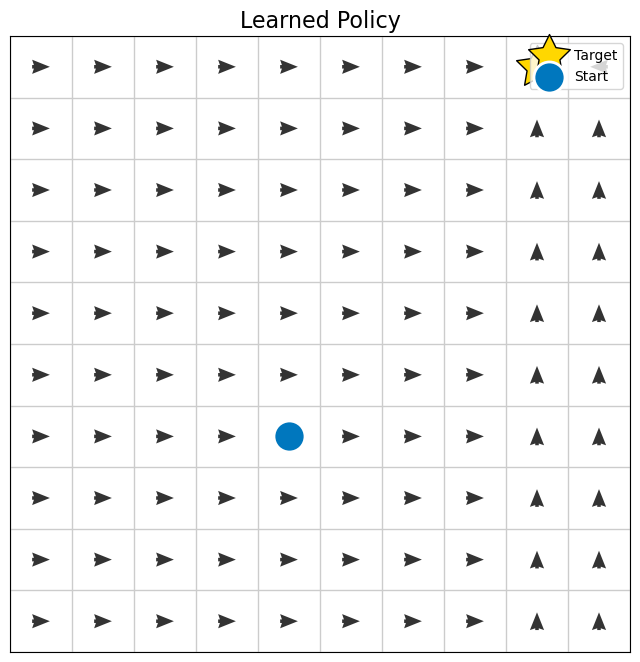


Displaying the agent's path animation:


In [ ]:

# ===================================================================
# --- MAIN EXECUTION BLOCK ---
# ===================================================================

# --- Common Setup ---
GRID_HEIGHT = 10
GRID_WIDTH = 10
AGENT_START = None
TARGET_POS = None

# 1. Create the environment
env = GridWorld(height=GRID_HEIGHT, width=GRID_WIDTH, 
                agent_location=AGENT_START, target_location=TARGET_POS)


# --- Choose Your Algorithm ---
# Model-Based Methods
# solver = ValueIterationSolver(env)
solver = PolicyIterationSolver(env)

# Model-Free Methods
# solver = QLearningSolver(env, num_episodes=10000)
# solver = MonteCarloSolver(env, num_episodes=50000)


# 2. Solve the MDP to find the optimal policy
start_time = time.time()
solver.solve()
end_time = time.time()
print(f"\nSolving took {end_time - start_time:.4f} seconds.")

# 3. Plot the extracted policy
print("\nDisplaying the learned policy:")
solver.plot_policy()

# 4. Run a simulation using the learned policy
history = solver.run_simulation(max_steps=100)

# 5. Visualize the agent's path
print("\nDisplaying the agent's path animation:")
env.set_history(history)
anim = env.Create_Visualization()

# Display the animation in a Jupyter Notebook or save it
HTML(anim.to_html5_video())
# To save: anim.save('gridworld_solution.mp4', writer='ffmpeg')

### b. VI

Starting Value Iteration...
Value Iteration Converged.

Solving took 0.0181 seconds.

Displaying the learned policy:


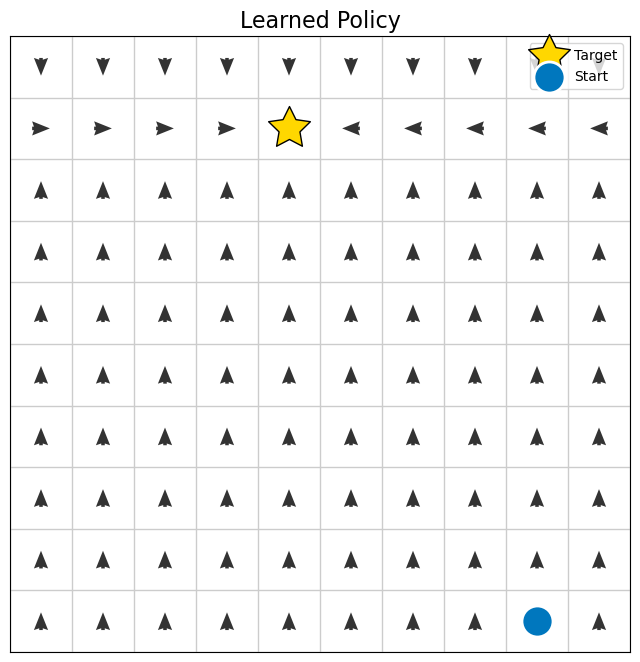


Displaying the agent's path animation:


In [ ]:

# ===================================================================
# --- MAIN EXECUTION BLOCK ---
# ===================================================================

# --- Common Setup ---
GRID_HEIGHT = 10
GRID_WIDTH = 10
AGENT_START = None
TARGET_POS = None

# 1. Create the environment
env = GridWorld(height=GRID_HEIGHT, width=GRID_WIDTH, 
                agent_location=AGENT_START, target_location=TARGET_POS)


# --- Choose Your Algorithm ---
# Model-Based Methods
solver = ValueIterationSolver(env)
# solver = PolicyIterationSolver(env)

# Model-Free Methods
# solver = QLearningSolver(env, num_episodes=10000)
# solver = MonteCarloSolver(env, num_episodes=50000)


# 2. Solve the MDP to find the optimal policy
start_time = time.time()
solver.solve()
end_time = time.time()
print(f"\nSolving took {end_time - start_time:.4f} seconds.")

# 3. Plot the extracted policy
print("\nDisplaying the learned policy:")
solver.plot_policy()

# 4. Run a simulation using the learned policy
history = solver.run_simulation(max_steps=100)

# 5. Visualize the agent's path
print("\nDisplaying the agent's path animation:")
env.set_history(history)
anim = env.Create_Visualization()

# Display the animation in a Jupyter Notebook or save it
HTML(anim.to_html5_video())
# To save: anim.save('gridworld_solution.mp4', writer='ffmpeg')

### c. Monte Carlo

Starting Monte Carlo Control...
  Episode 2000/50000 | Epsilon: 0.8187
  Episode 4000/50000 | Epsilon: 0.6703
  Episode 6000/50000 | Epsilon: 0.5488
  Episode 8000/50000 | Epsilon: 0.4493
  Episode 10000/50000 | Epsilon: 0.3679
  Episode 12000/50000 | Epsilon: 0.3012
  Episode 14000/50000 | Epsilon: 0.2466
  Episode 16000/50000 | Epsilon: 0.2019
  Episode 18000/50000 | Epsilon: 0.1653
  Episode 20000/50000 | Epsilon: 0.1353
  Episode 22000/50000 | Epsilon: 0.1108
  Episode 24000/50000 | Epsilon: 0.0907
  Episode 26000/50000 | Epsilon: 0.0743
  Episode 28000/50000 | Epsilon: 0.0608
  Episode 30000/50000 | Epsilon: 0.0498
  Episode 32000/50000 | Epsilon: 0.0408
  Episode 34000/50000 | Epsilon: 0.0334
  Episode 36000/50000 | Epsilon: 0.0273
  Episode 38000/50000 | Epsilon: 0.0224
  Episode 40000/50000 | Epsilon: 0.0183
  Episode 42000/50000 | Epsilon: 0.0150
  Episode 44000/50000 | Epsilon: 0.0123
  Episode 46000/50000 | Epsilon: 0.0100
  Episode 48000/50000 | Epsilon: 0.0100
  Episode 50

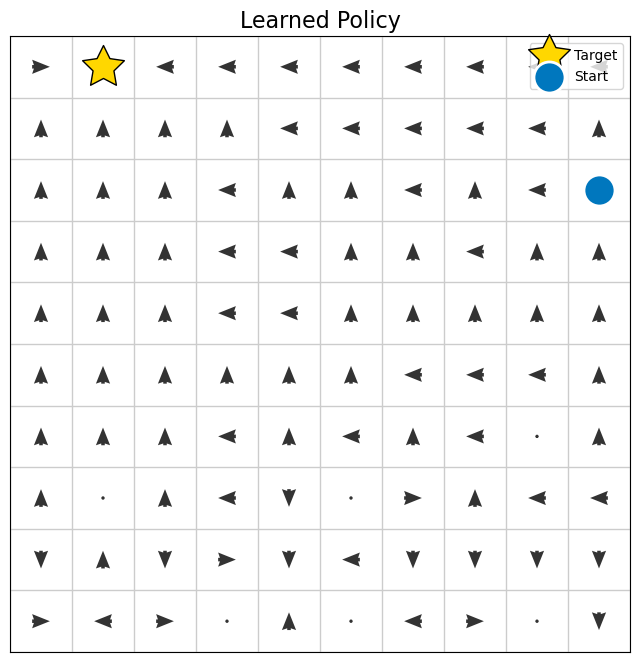


Displaying the agent's path animation:


In [ ]:

# ===================================================================
# --- MAIN EXECUTION BLOCK ---
# ===================================================================

# --- Common Setup ---
GRID_HEIGHT = 10
GRID_WIDTH = 10
AGENT_START = None
TARGET_POS = None

# 1. Create the environment
env = GridWorld(height=GRID_HEIGHT, width=GRID_WIDTH, 
                agent_location=AGENT_START, target_location=TARGET_POS)


# --- Choose Your Algorithm ---
# Model-Based Methods
# solver = ValueIterationSolver(env)
# solver = PolicyIterationSolver(env)

# Model-Free Methods
# solver = QLearningSolver(env, num_episodes=10000)
solver = MonteCarloSolver(env, num_episodes=50000)


# 2. Solve the MDP to find the optimal policy
start_time = time.time()
solver.solve()
end_time = time.time()
print(f"\nSolving took {end_time - start_time:.4f} seconds.")

# 3. Plot the extracted policy
print("\nDisplaying the learned policy:")
solver.plot_policy()

# 4. Run a simulation using the learned policy
history = solver.run_simulation(max_steps=100)

# 5. Visualize the agent's path
print("\nDisplaying the agent's path animation:")
env.set_history(history)
anim = env.Create_Visualization()

# Display the animation in a Jupyter Notebook or save it
HTML(anim.to_html5_video())
# To save: anim.save('gridworld_solution.mp4', writer='ffmpeg')

### d. Q-learning

Starting Q-Learning...
  Episode 1000/10000 | Epsilon: 0.6065
  Episode 2000/10000 | Epsilon: 0.3678
  Episode 3000/10000 | Epsilon: 0.2230
  Episode 4000/10000 | Epsilon: 0.1353
  Episode 5000/10000 | Epsilon: 0.0820
  Episode 6000/10000 | Epsilon: 0.0497
  Episode 7000/10000 | Epsilon: 0.0302
  Episode 8000/10000 | Epsilon: 0.0183
  Episode 9000/10000 | Epsilon: 0.0111
  Episode 10000/10000 | Epsilon: 0.0100
Q-Learning Finished.

Solving took 1.1663 seconds.

Displaying the learned policy:


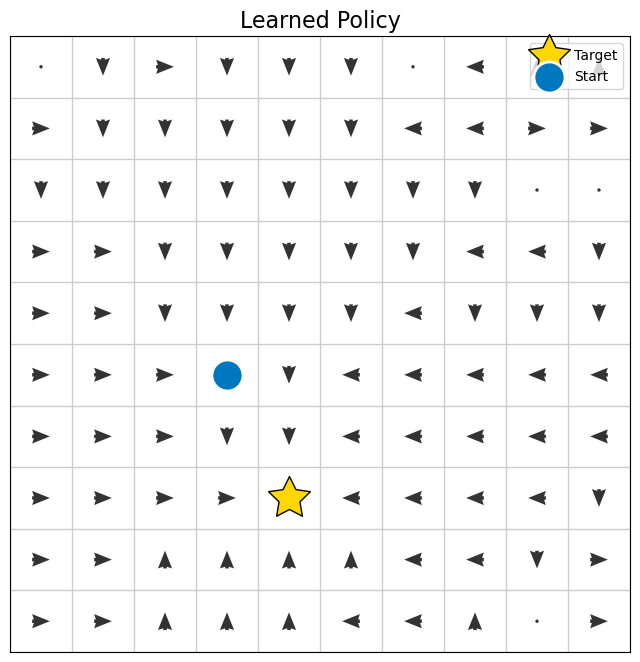


Displaying the agent's path animation:


In [ ]:

# ===================================================================
# --- MAIN EXECUTION BLOCK ---
# ===================================================================

# --- Common Setup ---
GRID_HEIGHT = 10
GRID_WIDTH = 10
AGENT_START = None
TARGET_POS = None

# 1. Create the environment
env = GridWorld(height=GRID_HEIGHT, width=GRID_WIDTH, 
                agent_location=AGENT_START, target_location=TARGET_POS)


# --- Choose Your Algorithm ---
# Model-Based Methods
# solver = ValueIterationSolver(env)
# solver = PolicyIterationSolver(env)

# Model-Free Methods
solver = QLearningSolver(env, num_episodes=10000)
# solver = MonteCarloSolver(env, num_episodes=50000)


# 2. Solve the MDP to find the optimal policy
start_time = time.time()
solver.solve()
end_time = time.time()
print(f"\nSolving took {end_time - start_time:.4f} seconds.")

# 3. Plot the extracted policy
print("\nDisplaying the learned policy:")
solver.plot_policy()

# 4. Run a simulation using the learned policy
history = solver.run_simulation(max_steps=100)

# 5. Visualize the agent's path
print("\nDisplaying the agent's path animation:")
env.set_history(history)
anim = env.Create_Visualization()

# Display the animation in a Jupyter Notebook or save it
HTML(anim.to_html5_video())
# To save: anim.save('gridworld_solution.mp4', writer='ffmpeg')